# Tutorial on fitting multiple datasets using MultiFitter
Often we have multiple datasets for a Miyake event. Instead of fitting a model to each dataset indivudually, we can use a MultiFitter object to fit to all the datasets at once! Here's how we can do it,

In [1]:
import numpy as np
import ticktack
import jax.numpy as jnp
from jax import jit
from ticktack import fitting
import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

In [2]:
ls ../../notebooks/775CE/

Büntgen18_CHN01.csv     Büntgen18_SWE05.csv     Jull14_Bristlecone.csv
Büntgen18_GER01.csv     Büntgen18_USA02.csv     Miyake12_Cedar.csv
Büntgen18_GER07.csv     Büntgen18_USA11.csv     Rakowski15_Oak.csv
Büntgen18_JAP01.csv     Büntgen18_USA18.csv     Scifo19_Oak.csv
Büntgen18_MON03.csv     Guttler15_Kauri.csv


First, we need to make a directory and place our datasets inside it. Each dataset should be a csv file, and has the same format as `example.csv`.


### Example 1: Fit a sinusoid model to the `775CE` Miyake event with `MCMC`.

In [3]:
mf, sampler = fitting.fit_event(year=775, # the year of the event
                                path='../../notebooks/775CE/', 
                                production_model="simple_sinusoid", 
                                sampler="MCMC", 
                                params=jnp.array([775.1, 0.3, 1.6, 6.5]), 
                                low_bounds=jnp.array([770., 0., 0, 0.]),
                                up_bounds=jnp.array([780., 5., 11, 15.]),
                                burnin=500, production=2000)

Retrieving data...


100%|███████████████████████████████████████████| 14/14 [00:03<00:00,  3.85it/s]


Running burn-in...


100%|█████████████████████████████████████████| 500/500 [02:22<00:00,  3.51it/s]


Running production...


100%|███████████████████████████████████████| 2000/2000 [09:26<00:00,  3.53it/s]


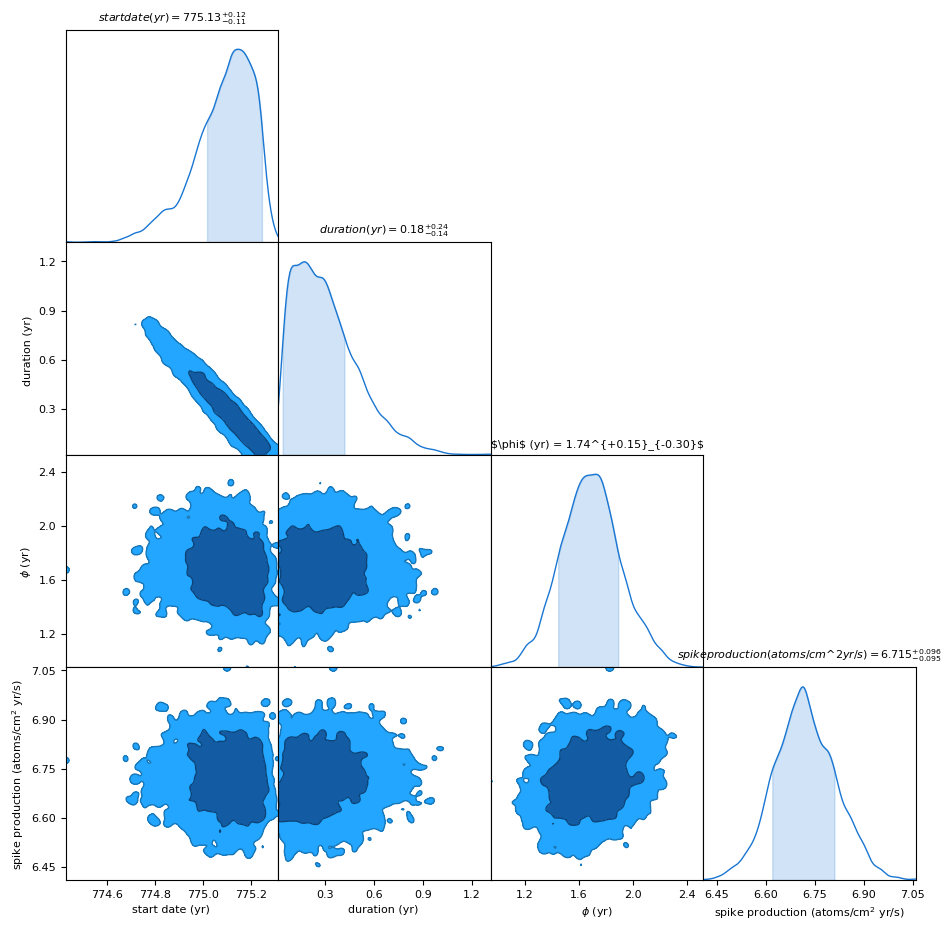

In [4]:
labels = ["start date (yr)", "duration (yr)", "$\phi$ (yr)", "spike production (atoms/cm$^2$ yr/s)"]
mf.chain_summary(sampler, walkers=8, labels=labels) # by default walker = dim(params) * 2

This is a rough estimate of the posterior of these parameters. We can get a much better corner plot if the burn-in steps and the production steps are higher (say 1000).

We can also define a custom parametric production model for fitting a MultiFitter. Here we will use a simple flat production function with a super gaussian spike. The only parameters for this model are: start date of the event, duration of the event, spike production

### Example 2: Fit a custom model to the `775CE` Miyake event with `MCMC`.

In [5]:
@jit
def super_gaussian(t, start_time, duration, area):
    middle = start_time + duration / 2.
    height = area / duration
    return height * jnp.exp(- ((t - middle) / (1. / 1.93516 * duration)) ** 16.)
@jit
def super_gaussian_pulse(t, *args):
    start_time, duration, area = jnp.array(list(args)).reshape(-1)
    height = super_gaussian(t, start_time, duration, area)
    production = 1.88 + height # 1.88 is the steady state production rate for Guttler15 model
    return production

In [6]:
mf, sampler = fitting.fit_event(year=775, 
                                path='../../notebooks/775CE/', 
                                production_model=super_gaussian_pulse, 
                                sampler="MCMC", 
                                params=jnp.array([775.1, 0.3, 6.5]), 
                                low_bounds=jnp.array([770., 0., 0.]),
                                up_bounds=jnp.array([780., 5., 15.]), 
                               burnin=500, production=2000)

Retrieving data...


100%|███████████████████████████████████████████| 14/14 [00:02<00:00,  5.39it/s]


Running burn-in...


100%|█████████████████████████████████████████| 500/500 [01:11<00:00,  6.97it/s]


Running production...


100%|███████████████████████████████████████| 2000/2000 [04:49<00:00,  6.92it/s]


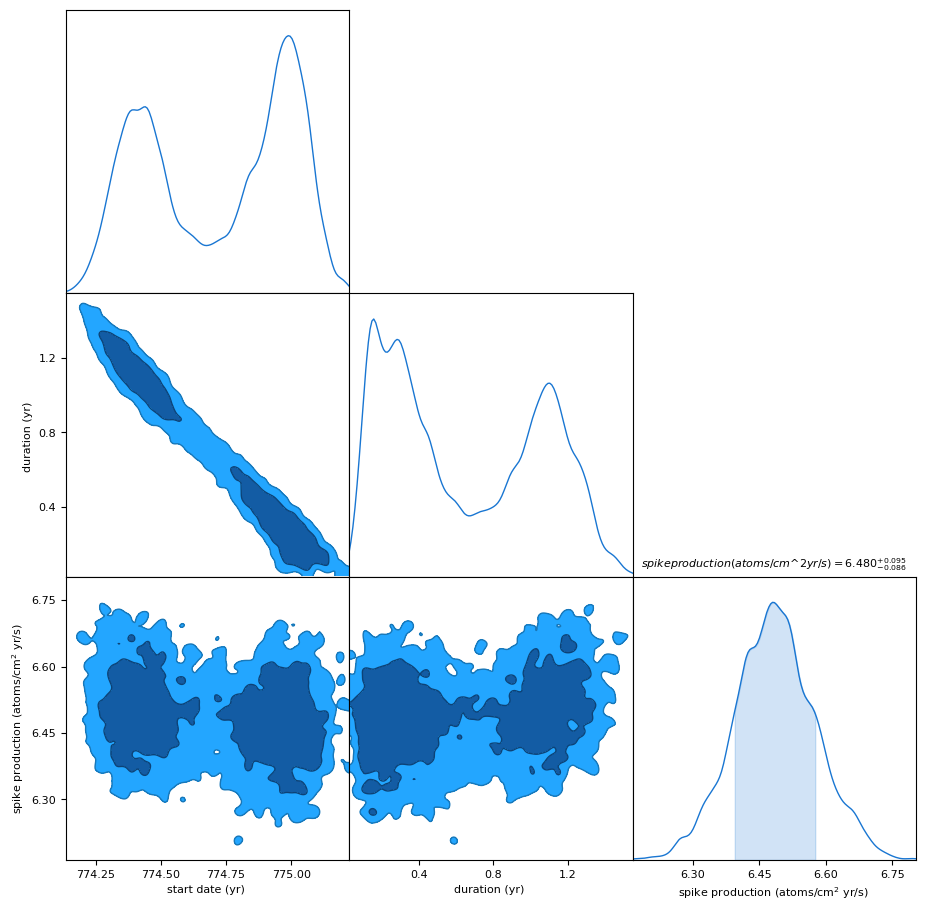

In [7]:
labels = ["start date (yr)", "duration (yr)", "spike production (atoms/cm$^2$ yr/s)"]
mf.chain_summary(sampler, walkers=6, labels=labels)